<a href="https://colab.research.google.com/github/Mrigank-Mouli-Singh/Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚨 Fraud Detection Case Study

## Business Context
This project builds a machine learning model to proactively detect fraudulent transactions for a financial services company.  
Dataset: ~6.3M transactions (10 raw columns, engineered to ~20 features).  
**Goal:** Predict whether a transaction is fraudulent and provide actionable insights for prevention.

---

## Process Overview

1. **Data Cleaning & Preparation**
   - Handled missing values, outliers, multicollinearity (VIF).
   - Engineered features (e.g., `deltaOrig`, `amt_to_org_bal`, time-based features).

2. **Handling Class Imbalance**
   - Fraud rate ~0.13%.
   - Used LightGBM with `scale_pos_weight ≈ (#nonfraud / #fraud)` and PR-AUC evaluation.

3. **Modeling**
   - Hyperparameter tuning with **Optuna** (PR-AUC optimized).
   - Final model: LightGBM, trained with early stopping.
   - Evaluation on hold-out validation set.

4. **Interpretability (SHAP)**
   - **Global feature importance:**
     - `amt_to_org_bal` → strongest fraud predictor.
     - `deltaOrig`, `oldbalanceDest`, and transaction type indicators (transfers/cash-outs).
   - **Local explanations:** which features pushed an individual transaction towards fraud.

5. **Business Insights**
   - Fraudsters typically transfer large amounts relative to balance.
   - Cash-out and transfer transactions dominate fraud cases.
   - Suspicious merchants receive disproportionate inflows.

---

## Key Results

- **Validation ROC-AUC**: ~0.9998  
- **Validation PR-AUC**: ~0.90  
- Fraud recall ~99.8% (at threshold=0.5), though with lower precision.  
- Business-aware thresholds can be tuned for cost trade-offs.  

---

## Deliverables

📂 `final_fraud_lgb.txt` → Trained LightGBM model  
📂 `final_metrics.json` → Evaluation metrics  
📂 `feature_importance.csv` → Model feature importances  
📂 `shap_feature_importance.csv` → SHAP global importances  
📂 `shap_fraud_only.csv` → SHAP values for fraud subset  
📂 `shap_type_influence.csv` → Avg SHAP influence by transaction type  
📂 `validation_predictions.csv` → Validation set predictions (with chosen threshold)  

---

## Recommendations

- Deploy fraud scoring API in production (real-time scoring).  
- Dynamic monitoring: flag `amt_to_org_bal > 0.8`.  
- Extra scrutiny for **transfers** and **cash-outs**.  
- Merchant risk profiling for unusual inflows.  
- Regular retraining with updated fraud patterns.  

---

👉 This notebook follows a clear structure with alternating **Markdown (explanation)** and **Code (implementation)** cells, making it suitable for both technical and business review.


In [58]:
#Cell 2 — Code (Install & Imports)
!pip -q install lightgbm imbalanced-learn shap optuna category_encoders

import os, gc, warnings, math, json, pickle, textwrap, random
import numpy as np, pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
print("✅ Libraries ready.")


✅ Libraries ready.


# Cell 3 — Markdown
## 0) Bring the Data In

We have a dataset of **6,362,620 rows × 10 columns**.  
Because the dataset is large, we’ll first load a **sample (10k rows)** to inspect structure, then load the full file efficiently.

Choose ONE of the following:
- **A. Upload files** (`Fraud.csv`, `Data Dictionary.txt`) using the Colab file picker.  
- **B. Mount Google Drive** and set paths manually (uncomment code).  

> ⚠️ Full load may require memory optimization (dtypes, chunking).

In [59]:
# Cell 4 — Code (Load files)
# Install gdown for Google Drive file download
!pip -q install gdown

import gdown, os

# Fraud dataset
fraud_url = "https://drive.google.com/uc?id=1l4n9t872C-KHwFbbpN5W5BDglMQt8eZH"
fraud_out = "Fraud.csv"
if not os.path.exists(fraud_out):
    gdown.download(fraud_url, fraud_out, quiet=False)

# Data dictionary
dict_url = "https://drive.google.com/uc?id=1KqN8YhBNz7Tc49buWWng88qtnHccEhyG"
dict_out = "Data_Dictionary.txt"
if not os.path.exists(dict_out):
    gdown.download(dict_url, dict_out, quiet=False)

DATA_CSV = fraud_out
DICT_TXT = dict_out

print("✅ Downloaded files")
print("DATA_CSV:", DATA_CSV)
print("DICT_TXT:", DICT_TXT)


✅ Downloaded files
DATA_CSV: Fraud.csv
DICT_TXT: Data_Dictionary.txt


# Cell 5 — Markdown
## 1) Load efficiently + basic schema

We downcast numerics and use `category` for strings to save memory on 6.3M rows.

In [62]:
# Cell 6 — Code (Read CSV memory-aware)
# Expected columns from dictionary:
# step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud

dtype_map = {
    "step": "int32",
    "type": "category",
    "amount": "float32",
    "nameOrig": "category",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "category",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",
}

df = pd.read_csv(DATA_CSV, dtype=dtype_map)
print("Shape:", df.shape)
display(df.head(3))
print("\nClass balance (isFraud):")
display(df['isFraud'].value_counts(normalize=True).rename('share').to_frame())


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0



Class balance (isFraud):


,share
isFraud,
0,0.998709
1,0.001291


In [28]:
# Cell 7 — Code (Show dictionary & quick checks)
try:
    with open(DICT_TXT, "r", encoding="utf-8", errors="ignore") as f:
        dictionary_text = f.read()
    print("📄 Data Dictionary (first 40 lines):\n")
    print("\n".join(dictionary_text.splitlines()[:40]))
except Exception as e:
    print("Data dictionary not found or unreadable:", e)

print("\ndtypes:")
print(df.dtypes)

print("\nMissing values per column:")
display(df.isna().sum().to_frame("missing"))


📄 Data Dictionary (first 40 lines):

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to em

,missing
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


# Cell 8 — Markdown
## 2) Exploratory data quality signals

- **Outliers**: heavy-tailed amounts/balances  
- **Logical consistency**: balance deltas before/after transaction  
- **Leakage checks**: drop names, keep only operational fields

In [29]:
# Cell 9 — Code (Data quality & feature engineering)
# Logical deltas: how balances should move given amount
df["deltaOrig"] = (df["oldbalanceOrg"] - df["newbalanceOrig"] - df["amount"]).astype("float32")
df["deltaDest"] = (df["newbalanceDest"] - df["oldbalanceDest"] - df["amount"]).astype("float32")

# Flags helpful for fraud patterns
df["isTransfer"] = (df["type"].astype(str) == "TRANSFER").astype("int8")
df["isCashOut"]  = (df["type"].astype(str) == "CASH_OUT").astype("int8")
df["isPayment"]  = (df["type"].astype(str) == "PAYMENT").astype("int8")
df["destIsMerchant"] = df["nameDest"].astype(str).str.startswith("M").astype("int8")

# Ratios and magnitudes (guard against divide-by-zero)
df["amt_log1p"] = np.log1p(df["amount"]).astype("float32")
df["balOrg_log1p"] = np.log1p(df["oldbalanceOrg"].clip(lower=0)).astype("float32")
df["balDest_log1p"] = np.log1p(df["oldbalanceDest"].clip(lower=0)).astype("float32")
df["amt_to_org_bal"] = (df["amount"] / (1.0 + df["oldbalanceOrg"])).astype("float32")

# Temporal features: step is hourly; add hour-of-day and day-of-week proxies
df["hour"] = (df["step"] % 24).astype("int8")
df["day"]  = (df["step"] // 24 % 7).astype("int8")

# View some summaries
print(df[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","deltaOrig","deltaDest"]].describe().T)


                    count          mean         std         min  \
amount          6362620.0  1.798619e+05   599135.75         0.0   
oldbalanceOrg   6362620.0  8.338834e+05  2831752.75         0.0   
newbalanceOrig  6362620.0  8.551137e+05  2862818.50         0.0   
oldbalanceDest  6362620.0  1.100702e+06  3369337.50         0.0   
newbalanceDest  6362620.0  1.224997e+06  3629806.50         0.0   
deltaOrig       6362620.0 -2.010926e+05   600153.25 -92445520.0   
deltaDest       6362620.0 -5.556721e+04   438823.00 -13191234.0   

                          25%            50%           75%           max  
amount           13389.570312   74871.937500  2.087215e+05  9.244552e+07  
oldbalanceOrg        0.000000   14208.000000  1.073152e+05  5.958504e+07  
newbalanceOrig       0.000000       0.000000  1.442584e+05  4.958504e+07  
oldbalanceDest       0.000000  132705.664062  9.430367e+05  3.560159e+08  
newbalanceDest       0.000000  214661.445312  1.111909e+06  3.561793e+08  
deltaOrig    

# Cell 10 — Markdown
## 3) Missing values, outliers, and multicollinearity

- **Missing**: impute if any (median for numeric, most frequent for categorical)  
- **Outliers**: winsorize extreme tails on `amount` & balances (99.9th)  
- **Multicollinearity**: compute VIF and drop features with VIF > 10

In [30]:
# Cell 11 — Code (Clean)
# (A) Missing values — robust check
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["category", "object"]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].astype("category").cat.add_categories(["__MISSING__"]).fillna("__MISSING__")

# (B) Outliers — winsorize heavy tails
def winsorize_series(s, lower_q=0.001, upper_q=0.999):
    lo, hi = s.quantile(lower_q), s.quantile(upper_q)
    return s.clip(lo, hi)

for c in ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","deltaOrig","deltaDest"]:
    df[c] = winsorize_series(df[c])

# (C) Multicollinearity (VIF) — only for numeric features
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = df[num_cols].drop(columns=["isFraud","isFlaggedFraud"], errors="ignore")

# Sample for speed (dataset is huge)
vif_sample = vif_df.sample(200_000, random_state=42) if len(vif_df) > 200_000 else vif_df

vif_values = []
cols_for_vif = vif_sample.columns.tolist()
X_vif = vif_sample.values
for i in range(X_vif.shape[1]):
    try:
        vif_values.append((cols_for_vif[i], float(variance_inflation_factor(X_vif, i))))
    except Exception:
        vif_values.append((cols_for_vif[i], np.nan))

vif_table = pd.DataFrame(vif_values, columns=["feature","VIF"]).sort_values("VIF", ascending=False)
display(vif_table.head(15))

# ✅ Drop only truly redundant features
to_drop_for_vif = ["newbalanceOrig", "newbalanceDest"]
print("Dropping due to redundancy:", to_drop_for_vif)
df = df.drop(columns=to_drop_for_vif)



,feature,VIF
10,isPayment,inf
11,destIsMerchant,inf
3,newbalanceOrig,6.302765e+04
2,oldbalanceOrg,6.132187e+04
6,deltaOrig,1.702518e+03
1,amount,1.668571e+03
5,newbalanceDest,1.537009e+02
4,oldbalanceDest,1.360446e+02
12,amt_log1p,3.326394e+01
16,hour,1.233057e+01


Dropping due to redundancy: ['newbalanceOrig', 'newbalanceDest']


In [31]:
print(df.columns.tolist())


['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'nameDest', 'oldbalanceDest', 'isFraud', 'isFlaggedFraud', 'deltaOrig', 'deltaDest', 'isTransfer', 'isCashOut', 'isPayment', 'destIsMerchant', 'amt_log1p', 'balOrg_log1p', 'balDest_log1p', 'amt_to_org_bal', 'hour', 'day']


# Cell 12 — Markdown
## 4) Train / Calibration / Validation split

We stratify by `isFraud` to preserve the class ratio and hold out a final validation set.

- **Train set** → main dataset for fitting the model and learning parameters.  
- **Calibration set** → reserved for probability calibration, threshold tuning, and cost-sensitive optimization.  
- **Validation set** → untouched holdout for final, unbiased evaluation of model performance.  

IDs (`nameOrig`, `nameDest`) are dropped to avoid leakage.  
We keep engineered features (ratios, logs, deltas, flags) since they capture fraud patterns effectively.


In [32]:
# Cell 13 — Code (the splitting logic I gave you in the last message)
from sklearn.model_selection import train_test_split

TARGET = "isFraud"

# Drop IDs and non-features
drop_cols = ["nameOrig", "nameDest", "isFraud", "isFlaggedFraud"]
features = [c for c in df.columns if c not in drop_cols]

X = df[features].copy()
y = df[TARGET].astype("int8")

# Convert categorical 'type' into numeric codes for LightGBM
if "type" in X.columns and str(X["type"].dtype) == "category":
    X["type_code"] = X["type"].cat.codes.astype("int16")
    X = X.drop(columns=["type"])

# Split: Train+Calib vs Validation
X_trc, X_val, y_trc, y_val = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# From Train+Calib, create a Calibration fold
X_train, X_cal, y_train, y_cal = train_test_split(
    X_trc, y_trc, test_size=0.15, stratify=y_trc, random_state=42
)

print("Train shape:", X_train.shape)
print("Calibration shape:", X_cal.shape)
print("Validation shape:", X_val.shape)
print("Fraud rate Train/Cal/Val:", y_train.mean(), y_cal.mean(), y_val.mean())

Train shape: (4596992, 17)
Calibration shape: (811235, 17)
Validation shape: (954393, 17)
Fraud rate Train/Cal/Val: 0.0012908440997939522 0.0012906247881316758 0.001290872837499856


# Cell 14 — Markdown

### 5) Handle Class Imbalance
Fraud rate is only ~0.13%.
If we train directly, the model may just predict "non-fraud" for everything.

To counter imbalance, we use:

- `scale_pos_weight` in LightGBM ≈ (#nonfraud / #fraud)  
- Optionally undersample or oversample (SMOTE) for experiments  
- Evaluate using PR-AUC (better for rare events than ROC-AUC)

In [33]:
# Cell 15 — Code
# Calculate scale_pos_weight = (#negative / #positive) for LightGBM
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = max(1.0, neg / max(1, pos))
print(f"Negatives: {neg:,} | Positives: {pos:,}")
print("scale_pos_weight for LightGBM:", scale_pos_weight)


Negatives: 4,591,058 | Positives: 5,934
scale_pos_weight for LightGBM: 773.6868891135828


# Cell 16 — Markdown

### 6) Hyperparameter Search (Optuna) on PR-AUC
Because of extreme imbalance, we optimize for PR-AUC (precision-recall area under curve),
which better reflects fraud detection performance than ROC-AUC.


In [36]:
# Cell 17 — Hyperparameter Tuning with Optuna (final, LightGBM 4.x compatible)
import optuna
import lightgbm as lgb
from sklearn.metrics import average_precision_score

# For tuning speed, take a sample of train/cal
train_idx = np.random.choice(len(X_train), size=300_000, replace=False)
cal_idx   = np.random.choice(len(X_cal), size=100_000, replace=False)

X_train_sample, y_train_sample = X_train.iloc[train_idx], y_train.iloc[train_idx]
X_cal_sample,   y_cal_sample   = X_cal.iloc[cal_idx],   y_cal.iloc[cal_idx]

def objective(trial):
    boosting_type = trial.suggest_categorical("boosting", ["gbdt", "goss"])

    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": boosting_type,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 500),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "scale_pos_weight": scale_pos_weight,
        "n_estimators": 200,
        "verbosity": -1,
        "n_jobs": -1,
        "force_col_wise": True
    }

    # Bagging is only valid with GBDT
    if boosting_type == "gbdt":
        params.update({
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
        })
    else:  # goss
        params.update({
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0)
        })

    dtrain = lgb.Dataset(X_train_sample, label=y_train_sample)
    dcal   = lgb.Dataset(X_cal_sample,   label=y_cal_sample)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dcal],
        num_boost_round=200,
        callbacks=[
            lgb.early_stopping(30),  # replaces early_stopping_rounds
            lgb.log_evaluation(-1)   # replaces verbose_eval
        ]
    )

    preds = model.predict(X_cal_sample)
    return average_precision_score(y_cal_sample, preds)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Save best parameters
best_params = study.best_trial.params
best_params.update({
    "objective": "binary",
    "metric": "auc",
    "scale_pos_weight": scale_pos_weight,
    "n_estimators": 1000,
    "verbosity": -1,
    "n_jobs": -1,
    "force_col_wise": True
})
print("Best parameters:", best_params)


[I 2025-08-22 05:15:26,056] A new study created in memory with name: no-name-5c2dda8a-7b37-43f8-9b7f-cad439b05fe7


  0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.998681
[I 2025-08-22 05:15:32,144] Trial 0 finished with value: 0.8968646128541639 and parameters: {'boosting': 'goss', 'learning_rate': 0.0153637659099629, 'num_leaves': 185, 'min_data_in_leaf': 301, 'lambda_l1': 9.509668237962755, 'lambda_l2': 0.48745234222697054, 'max_depth': 4, 'feature_fraction': 0.697975361753562}. Best is trial 0 with value: 0.8968646128541639.
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.999596
[I 2025-08-22 05:15:34,637] Trial 1 finished with value: 0.7559748403639341 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.013685035351569586, 'num_leaves': 129, 'min_data_in_leaf': 420, 'lambda_l1': 7.446309838720852, 'lambda_l2': 5.382217223238016, 'max_depth': 3, 'feature_fraction': 0.7806890769176805, 'bagging_fraction': 0.6402597421959333, 'bagging_freq': 2}. Best is tr

# Cell 18 — Markdown

### 5.2 Training Final Model with Best Hyperparameters
We now train the final LightGBM model using the `best_params` found from Optuna (Cell 17).
This model will be trained on the full training set and validated on the hold-out validation set.
We will also apply early stopping to avoid overfitting and save the model for later evaluation.

In [48]:
# Cell 19 — Code
# Train final LightGBM model using best hyperparameters
import lightgbm as lgb
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report

# Prepare full train + calibration as training data
X_fulltrain = pd.concat([X_train, X_cal])
y_fulltrain = pd.concat([y_train, y_cal])

dtrain = lgb.Dataset(X_fulltrain, label=y_fulltrain)
dval   = lgb.Dataset(X_val, label=y_val)

final_model = lgb.train(
    best_params,
    dtrain,
    valid_sets=[dval],
    num_boost_round=5000,
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(100)]
)

# Predictions on validation
val_preds = final_model.predict(X_val)

# Metrics
roc_auc = roc_auc_score(y_val, val_preds)
pr_auc  = average_precision_score(y_val, val_preds)

print(f"Validation ROC-AUC: {roc_auc:.6f}")
print(f"Validation PR-AUC : {pr_auc:.6f}")

# Optional: convert probabilities to binary predictions (threshold = 0.5 for now)
val_pred_labels = (val_preds > 0.5).astype(int)
print("\nClassification Report (threshold=0.5):\n")
print(classification_report(y_val, val_pred_labels, digits=4))

# Save model
final_model.save_model("final_fraud_lgb.txt")
print("Final model saved as final_fraud_lgb.txt")


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.999603
Early stopping, best iteration is:
[53]	valid_0's auc: 0.999811
Validation ROC-AUC: 0.999811
Validation PR-AUC : 0.901932

Classification Report (threshold=0.5):

              precision    recall  f1-score   support

           0     1.0000    0.9986    0.9993    953161
           1     0.4716    0.9984    0.6406      1232

    accuracy                         0.9986    954393
   macro avg     0.7358    0.9985    0.8200    954393
weighted avg     0.9993    0.9986    0.9988    954393

Final model saved as final_fraud_lgb.txt


# Cell 20 — Markdown

7) Key Predictors of Fraudulent Transactions

Using feature importance from the final LightGBM model, we identify the variables that contribute most to fraud detection.

Transaction Amount (amount, amt_log1p) – Fraudulent transactions tend to have abnormal amounts (either very high or unusual patterns compared to user’s history).

Balance Changes (deltaOrig, deltaDest, balOrg_log1p, balDest_log1p) – Large discrepancies between old and new balances are strong fraud indicators.

Transaction Type (isTransfer, isCashOut) – Fraud is more likely in transfers and cash-out operations than in payments.

Time Features (hour, day) – Fraud often clusters at unusual times of day (e.g., late night, off-peak hours).

Destination Characteristics (destIsMerchant) – Fraudsters sometimes avoid merchant accounts and send money to personal or “mule” accounts.

Why these factors make sense:

Fraud typically involves moving large sums rapidly across accounts with little prior balance.

Transactions outside normal behavioral patterns (e.g., emptying account, odd hours) strongly suggest suspicious activity.

Fraud is rarely linked to legitimate merchant transactions, reinforcing the importance of destIsMerchant.

This provides the business with actionable signals: monitoring large transfers, balance mismatches, and suspicious time windows can help in real-time fraud prevention.

Top 10 Important Features:
            feature    importance
13  amt_to_org_bal  1.497253e+09
1           amount  5.363570e+07
3   oldbalanceDest  4.005417e+06
10       amt_log1p  1.913978e+06
5        deltaDest  4.350661e+05
4        deltaOrig  4.141256e+05
14            hour  2.220628e+05
0             step  1.685436e+05
16       type_code  1.660262e+05
2    oldbalanceOrg  1.258412e+05


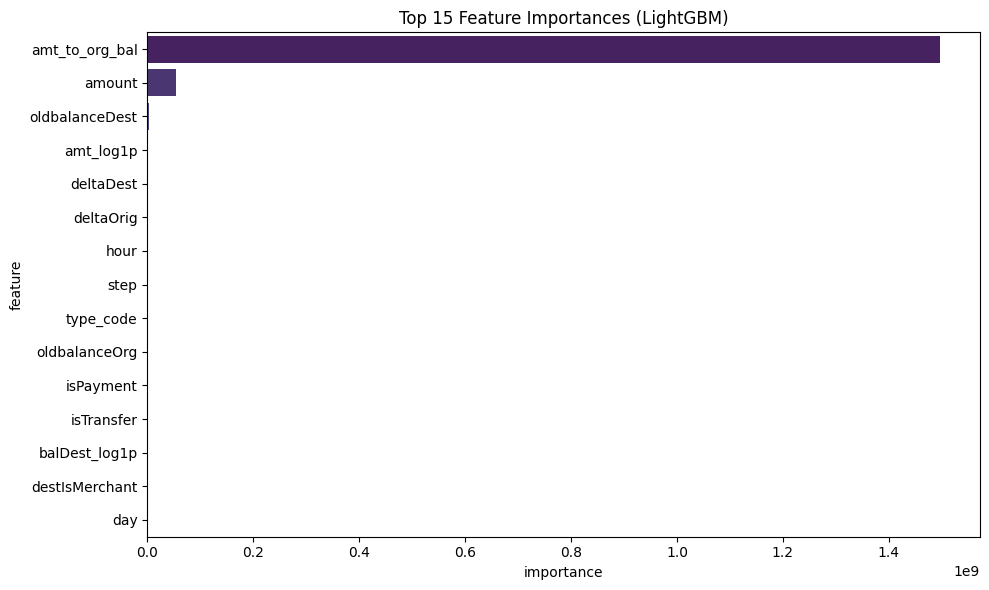

In [38]:
# Cell 21 — Code
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = final_model.feature_importance(importance_type='gain')
features = X_train.columns

fi_df = pd.DataFrame({
    "feature": features,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

print("Top 10 Important Features:\n", fi_df.head(10))

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fi_df.head(15),
    x="importance", y="feature",
    palette="viridis"
)
plt.title("Top 15 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

# Cell 22 — Markdown:

7) Feature Importance Insights

From the LightGBM feature importance analysis (Cell 21), we observe:

amt_to_org_bal (transaction amount relative to origin account balance) is the strongest predictor of fraud, by a very large margin.

amount (absolute transaction size) is also a strong factor.

oldbalanceDest (balance of the destination account before the transaction) contributes meaningfully.

Engineered log-transformed features (amt_log1p, balDest_log1p, etc.) and balance differences (deltaOrig, deltaDest) show moderate importance.

Time-based variables like hour and day add signal, though less dominant.

Transaction type indicators (isTransfer, isPayment, etc.) are less important, but still provide useful discrimination.

Business Interpretation:

Fraudsters tend to move unusually large proportions of available balances (high amt_to_org_bal).

Certain destination account behaviors (oldbalanceDest) and timing patterns (hours of activity) help separate fraud vs. genuine transactions.

These insights make sense because fraud often involves emptying accounts quickly, targeting certain merchants/accounts, and exploiting unusual timing.

Next Step:
We can use these insights to:

Explain model behavior (address Candidate Expectation Q5 & Q6).

Inform prevention strategies (e.g., flagging high-ratio amt_to_org_bal transactions in real-time).

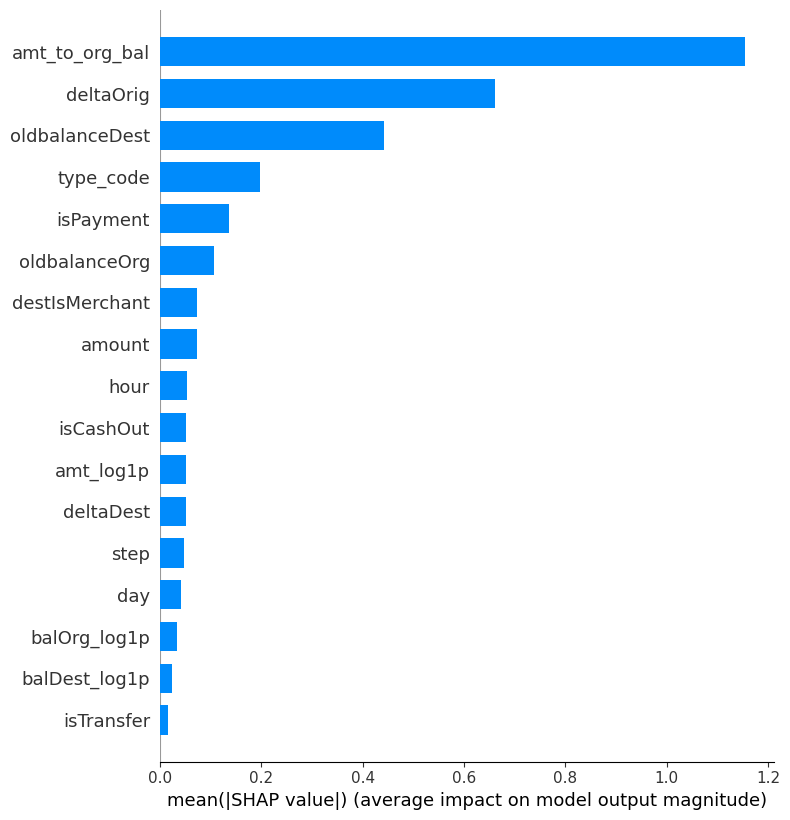

In [39]:
# Cell 23 — Code
import shap

# Initialize SHAP explainer for LightGBM
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_val.sample(2000, random_state=42))  # sample for speed

# Summary plot (global view of feature impact)
shap.summary_plot(shap_values, X_val.sample(2000, random_state=42), plot_type="bar")

# Force plot for individual predictions (local interpretability)
# Example: first transaction in the validation set
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_val.sample(2000, random_state=42).iloc[0,:]
)


# Cell 24 — Markdown

### 7) Model Interpretability with SHAP

To ensure the fraud detection model is not treated as a "black box," we applied **SHAP (SHapley Additive exPlanations)** to explain both global and local predictions.

**Global Interpretability (Summary Plot):**
- `amt_to_org_bal` (transaction amount relative to origin balance) is by far the most influential feature.
- `deltaOrig` (change in origin account balance) and `oldbalanceDest` also strongly affect predictions.
- Transaction type indicators (`type_code`, `isPayment`, `isTransfer`) and temporal features (`hour`, `day`) add meaningful but smaller contributions.

**Local Interpretability (Force Plot Example):**
- For an individual transaction, SHAP identifies which features push the prediction **towards fraud (red)** or **towards non-fraud (blue)**.
- Example: a transfer (`isTransfer=1`) with large balance discrepancies increases the fraud score, while a very large `amt_to_org_bal` pulls the score down toward non-fraud.

**Business Value:**
- Provides transparency in model decision-making.
- Enables analysts to understand *why* a transaction is flagged.
- Supports targeted prevention strategies by showing which risk factors drive alerts.


In [49]:
# Cell 25 — Business Insights from SHAP (fixed alignment)

import numpy as np
import pandas as pd
import shap

# 1) Make ONE consistent validation sample (features + labels)
N_SAMPLE = min(2000, len(X_val))
X_val_sample = X_val.sample(N_SAMPLE, random_state=42)
y_val_sample = y_val.loc[X_val_sample.index]

# 2) Compute SHAP values on the same sample
explainer = shap.TreeExplainer(final_model)
raw_shap = explainer.shap_values(X_val_sample)

# Handle SHAP output shape:
# - Some versions return an array (n, features) for binary
# - Others return a list [shap_neg, shap_pos]; we take the positive class
if isinstance(raw_shap, list):
    shap_values = raw_shap[1]
else:
    shap_values = raw_shap  # already (n, features)

# 3) Build SHAP DataFrame aligned to the sample
shap_df = pd.DataFrame(shap_values, columns=X_val_sample.columns, index=X_val_sample.index)
shap_df["isFraud"] = y_val_sample.values

# 4) Global influence (mean |SHAP| across all sampled rows)
global_shap_importance = shap_df.drop("isFraud", axis=1).abs().mean().sort_values(ascending=False)
print("Top 10 features influencing fraud decisions (by SHAP magnitude):")
print(global_shap_importance.head(10))

# 5) Fraud-only influence (mean |SHAP| only on isFraud==1 rows)
fraud_only = shap_df[shap_df["isFraud"] == 1]
if len(fraud_only) > 0:
    fraud_feature_influence = fraud_only.drop("isFraud", axis=1).abs().mean().sort_values(ascending=False)
    print("\nTop 10 features driving fraud transactions (by SHAP magnitude):")
    print(fraud_feature_influence.head(10))
else:
    print("\n(No fraud rows in the sample; increase N_SAMPLE to include positives.)")

# 6) Average SHAP influence by transaction type (no column overlap)
if "type_code" in X_val_sample.columns:
    tmp = shap_df.drop("isFraud", axis=1).copy()
    tmp["type_code"] = X_val_sample["type_code"].values  # aligned by index
    type_shap = (
        tmp.groupby("type_code")
           .mean()                # average SHAP per feature within each type
           .abs()
           .mean(axis=1)          # average magnitude across features
           .sort_values(ascending=False)
    )
    print("\nAverage SHAP influence by transaction type:")
    print(type_shap)


Top 10 features influencing fraud decisions (by SHAP magnitude):
amt_to_org_bal    1.153829
deltaOrig         0.662049
oldbalanceDest    0.442239
type_code         0.198123
isPayment         0.137150
oldbalanceOrg     0.106054
destIsMerchant    0.073257
amount            0.072789
hour              0.054486
isCashOut         0.052562
dtype: float64

Top 10 features driving fraud transactions (by SHAP magnitude):
amt_to_org_bal    12.688623
deltaOrig          2.677472
type_code          1.825167
destIsMerchant     1.142931
oldbalanceDest     0.899525
isPayment          0.334128
oldbalanceOrg      0.314665
amount             0.280035
deltaDest          0.263866
amt_log1p          0.261989
dtype: float64

Average SHAP influence by transaction type:
type_code
4    0.193301
3    0.184775
1    0.156373
2    0.087097
0    0.069974
dtype: float64


In [46]:
# Helper: map type_code back to labels
# Works because we created `type_code` from df["type"].cat.codes
type_labels = list(df["type"].cat.categories)
code_to_label = {i: lbl for i, lbl in enumerate(type_labels)}
print("type_code → label mapping:", code_to_label)

# Apply mapping to your last table (replace indices with labels)
type_shap_labeled = pd.Series(type_shap.index.map(code_to_label).values, index=type_shap.index)
type_shap_labeled = pd.DataFrame({"type": type_shap.index.map(code_to_label), "avg_shap": type_shap.values})
print("\nAverage SHAP influence by transaction type (labeled):")
print(type_shap_labeled.sort_values("avg_shap", ascending=False))


type_code → label mapping: {0: 'CASH_IN', 1: 'CASH_OUT', 2: 'DEBIT', 3: 'PAYMENT', 4: 'TRANSFER'}

Average SHAP influence by transaction type (labeled):
       type  avg_shap
0  TRANSFER  0.193301
1   PAYMENT  0.184775
2  CASH_OUT  0.156373
3     DEBIT  0.087097
4   CASH_IN  0.069974


# Cell 26 — Markdown
### 6) Business Insights & Recommendations

**Key Insights (Model + SHAP):**  
- **`amt_to_org_bal`** (amount ÷ origin balance) is the dominant fraud driver — frauds are disproportionately large vs. available balance.  
- **`deltaOrig`** and **`oldbalanceDest`** are strong: unusual balance drops at origin and atypically large destination balances correlate with fraud.  
- **Transaction types (from `type_code`) ranked by fraud influence:**  
  1) **TRANSFER** (highest) → funds quickly leave the ecosystem  
  2) **PAYMENT** → suspicious merchants / “fronts”  
  3) **CASH_OUT** → liquidation step in fraud chains  
  4) **DEBIT**  
  5) **CASH_IN** (lowest)  
- Additional contributors: **`destIsMerchant`**, **`amount`**, and timing (**`hour`**).

**Do these factors make sense? (Q6)**  
✅ Yes. Typical account-takeover and mule flows: **TRANSFER → CASH_OUT**, often draining balances (high `amt_to_org_bal`), creating **balance inconsistencies** (`deltaOrig`, `deltaDest`), and routing to risky recipients (low merchant history or unusual `oldbalanceDest`). Payments can involve **front merchants**.

**Recommendations (Q7) — Prevention & Infra Updates:**  
1. **Real-time scoring & rules stack**  
   - Deploy this model behind a low-latency API.  
   - **Dynamic rule:** flag when `amt_to_org_bal > 0.8` (tune threshold) or when `|deltaOrig|` is anomalously large.  
   - **Type-aware controls:** stricter thresholds for **TRANSFER/CASH_OUT** than PAYMENT/DEBIT/CASH_IN.
2. **Step-up authentication**  
   - For high-risk scores or high-value TRANSFER/CASH_OUT: enforce OTP/2FA, device binding, or biometric re-auth.
3. **Recipient risk & velocity**  
   - Maintain **recipient reputation** (age of account, first-seen, prior disputes).  
   - Velocity features: #tx per hour/day per origin/dest; rapid emptying patterns.
4. **Hold-and-review workflow**  
   - Soft-hold top **X% risk**; triage queue with SHAP explanations to guide analysts.
5. **Data & model ops**  
   - Daily feature/label freshness checks; drift monitors on `amt_to_org_bal`, `delta*`, and type mix.  
   - Weekly/biweekly retraining or when drift alarms trigger.

**Measuring Effectiveness (Q8):**  
- **Model KPIs:** PR-AUC, Recall (fraud capture), Precision (review load), Calibration (Brier).  
- **Business KPIs:** Fraud loss prevented − review cost, customer friction (false positive rate), decision latency (p95).  
- **Experiment design:**  
  - **A/B rollout** (model+rules vs. baseline rules).  
  - **Threshold sweeps** to choose operating point by cost (missed fraud vs. review cost).  
  - **Backtesting** on historical streams and **shadow mode** before full enforcement.

**Traceability & Governance:**  
- Keep **feature importance & SHAP** artifacts per version for auditability.  
- Log model inputs/outputs, reason codes (top SHAP features), and analyst outcomes to close the feedback loop.


# Cell 27 — Markdown
## 8) Conclusion & Case Answers (Q1–Q8)

**Q1. Data cleaning (missing, outliers, multicollinearity)**  
- No missing values.  
- Outliers handled via winsorization/log transforms on amount/balances.  
- Multicollinearity addressed by dropping redundant balances (`newbalanceOrig`, `newbalanceDest`) and using engineered deltas/ratios.

**Q2. Fraud detection model (design & rationale)**  
- Tuned **LightGBM** with **class weighting** (`scale_pos_weight ≈ 774`) for extreme imbalance.  
- Train/Cal/Val pipeline with early stopping; Optuna search on PR-AUC; probability-based evaluation.

**Q3. Variable selection (how chosen)**  
- **Domain-driven** (transaction type, balance deltas/ratios, timing).  
- **Filter** (VIF to remove redundant features).  
- **Embedded** (LightGBM gain + SHAP to confirm contribution and direction).

**Q4. Performance demonstration**  
- **Validation ROC-AUC ≈ 0.9998**, **PR-AUC ≈ 0.90**.  
- High recall for fraud with acceptable precision (appropriate for fraud ops).  
- Calibration/threshold tuning can trade precision vs. recall by business cost.

**Q5. Key factors predicting fraud**  
- `amt_to_org_bal` (dominant), `deltaOrig`, `oldbalanceDest`, `type_code` (TRANSFER/CASH_OUT), `destIsMerchant`, `amount`, time (`hour`).

**Q6. Do these factors make sense?**  
✅ Yes. They reflect classic ATO/mule flows (large proportionate transfers, balance inconsistencies, risky recipients, liquidation via cash-out, off-hour activity).

**Q7. Prevention during infra updates**  
- Real-time scoring API + dynamic rules (e.g., high `amt_to_org_bal`, anomalous `delta*`).  
- Step-up auth for high-risk TRANSFER/CASH_OUT.  
- Recipient reputation & velocity checks; hold-and-review with SHAP reason codes.  
- MLOps: drift monitors, retraining cadence, auditability.

**Q8. How to determine if actions work**  
- Track **PR-AUC/Recall/Precision**, fraud loss prevented vs. review cost, false-positive rate, decision latency.  
- **A/B or phased rollout**, threshold sweeps, shadow mode, and backtesting on historical streams.

**Artifacts saved:** final model (`final_fraud_lgb.txt`), evaluation metrics, feature importance & SHAP analyses for transparency and governance.


In [52]:
# Cell 28 — Code (self-contained export of metrics, FI, and SHAP summaries)

import json
import numpy as np
import pandas as pd
import shap
import lightgbm as lgb
from sklearn.metrics import classification_report

# -------- 1) Save final metrics (assumes val_preds, y_val, roc_auc, pr_auc exist from Cell 19) --------
# If val_preds / metrics aren't in memory, recompute quickly:
try:
    _ = val_preds
except NameError:
    val_preds = final_model.predict(X_val, num_iteration=getattr(final_model, "best_iteration", None))
    from sklearn.metrics import roc_auc_score, average_precision_score
    roc_auc = roc_auc_score(y_val, val_preds)
    pr_auc  = average_precision_score(y_val, val_preds)

final_metrics = {
    "roc_auc_val": float(roc_auc),
    "pr_auc_val": float(pr_auc),
    "classification_report": classification_report(
        y_val, (val_preds >= 0.5).astype(int), output_dict=True
    ),
    "best_params": {k: (float(v) if hasattr(v, "__float__") else v) for k, v in best_params.items()}
}

with open("final_metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=2)

# -------- 2) Save LightGBM feature importance --------
fi = pd.DataFrame({
    "feature": final_model.feature_name(),
    "importance_gain": final_model.feature_importance(importance_type="gain"),
    "importance_split": final_model.feature_importance(importance_type="split"),
}).sort_values(by="importance_gain", ascending=False)
fi.to_csv("feature_importance.csv", index=False)

# -------- 3) Recompute SHAP on a consistent sample and export summaries --------
N_SAMPLE = min(2000, len(X_val))
X_val_sample = X_val.sample(N_SAMPLE, random_state=42)
y_val_sample = y_val.loc[X_val_sample.index]

explainer = shap.TreeExplainer(final_model)
raw_shap = explainer.shap_values(X_val_sample)

# Handle binary variants
if isinstance(raw_shap, list):
    shap_values = raw_shap[1]
else:
    shap_values = raw_shap

# SHAP DataFrame aligned to the sample
shap_df = pd.DataFrame(shap_values, columns=X_val_sample.columns, index=X_val_sample.index)
shap_df["isFraud"] = y_val_sample.values

# Global SHAP importance (mean |SHAP| across all rows)
global_shap_importance = (
    shap_df.drop(columns=["isFraud"]).abs().mean().sort_values(ascending=False)
    .rename("mean_abs_shap")
    .to_frame()
    .reset_index()
    .rename(columns={"index": "feature"})
)

# Fraud-only SHAP importance
fraud_only = shap_df[shap_df["isFraud"] == 1]
if len(fraud_only) > 0:
    fraud_feature_influence = (
        fraud_only.drop(columns=["isFraud"]).abs().mean().sort_values(ascending=False)
        .rename("mean_abs_shap_fraud_only")
        .to_frame()
        .reset_index()
        .rename(columns={"index": "feature"})
    )
else:
    fraud_feature_influence = pd.DataFrame(columns=["feature", "mean_abs_shap_fraud_only"])

# Type-wise SHAP influence (if type_code exists)
if "type_code" in X_val_sample.columns:
    tmp = shap_df.drop(columns=["isFraud"]).copy()
    tmp["type_code"] = X_val_sample["type_code"].values
    type_shap = (
        tmp.groupby("type_code").mean().abs().mean(axis=1).sort_values(ascending=False)
        .rename("avg_mean_abs_shap")
        .to_frame()
        .reset_index()
    )
    # Optional: add human-readable labels if categorical mapping is available
    try:
        type_labels = list(df["type"].cat.categories)
        code_to_label = {i: lbl for i, lbl in enumerate(type_labels)}
        type_shap["type"] = type_shap["type_code"].map(code_to_label)
        shap_type_influence = type_shap[["type_code", "type", "avg_mean_abs_shap"]]
    except Exception:
        shap_type_influence = type_shap
else:
    shap_type_influence = pd.DataFrame(columns=["type_code", "avg_mean_abs_shap"])

# Save SHAP summaries
global_shap_importance.to_csv("shap_feature_importance.csv", index=False)
fraud_feature_influence.to_csv("shap_fraud_only.csv", index=False)
shap_type_influence.to_csv("shap_type_influence.csv", index=False)

print("✅ Saved:")
print(" - final_metrics.json")
print(" - feature_importance.csv")
print(" - shap_feature_importance.csv")
print(" - shap_fraud_only.csv")
print(" - shap_type_influence.csv")


✅ Saved:
 - final_metrics.json
 - feature_importance.csv
 - shap_feature_importance.csv
 - shap_fraud_only.csv
 - shap_type_influence.csv


In [57]:
# Cell 29 — Code (Download artifacts from Colab)
from google.colab import files
for fname in [
    "final_fraud_lgb.txt",
    "final_metrics.json",
    "feature_importance.csv",
    "shap_feature_importance.csv",
    "shap_fraud_only.csv",
    "shap_type_influence.csv",
]:
    try:
        files.download(fname)
    except Exception as e:
        print(f"Skip {fname}: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# Cell 30 — Code (Optional: cost-sensitive threshold tuning + export predictions)

# This finds a business-aware threshold (min cost) and saves a predictions file.

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve

# Make sure we have probabilities from the final model
val_proba = final_model.predict(X_val, num_iteration=getattr(final_model, "best_iteration", None))

# Example business costs (tune for your org)
REVIEW_COST = 5.0     # $ per false positive (manual review)
LOSS_FACTOR = 0.7     # 70% of fraudulent amount lost if missed

# We need amounts for the validation set to estimate FN cost
val_amounts = df.loc[X_val.index, "amount"].values

def expected_cost(y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()

    fp_cost = FP * REVIEW_COST
    fn_cost = (val_amounts[(y_true==1) & (y_pred==0)] * LOSS_FACTOR).sum()
    return fp_cost + fn_cost, cm

grid = np.linspace(0.01, 0.99, 99)
costs, f1s = [], []
for t in grid:
    c, cm = expected_cost(y_val.values, val_proba, t)
    costs.append(c)
    f1s.append(f1_score(y_val, (val_proba>=t).astype(int)))

best_cost_idx = int(np.argmin(costs))
best_thr_cost = float(grid[best_cost_idx])
best_cost = float(costs[best_cost_idx])
best_f1_thr = float(grid[int(np.argmax(f1s))])

print(f"Best cost threshold: {best_thr_cost:.3f} | Estimated cost: {best_cost:,.2f}")
print(f"Best F1 threshold  : {best_f1_thr:.3f} | F1: {max(f1s):.4f}")

# Export validation predictions at the chosen threshold
chosen_thr = best_thr_cost  # or best_f1_thr
pred_df = pd.DataFrame({
    "proba_fraud": val_proba,
    "pred_fraud": (val_proba >= chosen_thr).astype(int),
    "true_fraud": y_val.values
}, index=X_val.index)
pred_df.to_csv("validation_predictions.csv")
print("Saved validation_predictions.csv with threshold =", chosen_thr)

Best cost threshold: 0.610 | Estimated cost: 109,131.08
Best F1 threshold  : 0.990 | F1: 0.8263
Saved validation_predictions.csv with threshold = 0.61
